#### imports etc 

In [39]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.datasets import ImageFolder
import pickle
from collections import Counter

from dotenv import load_dotenv
load_dotenv()

PATH_TO_PLANTNET_300K = os.environ.get('PATH_TO_PLANTNET_300K')

def count_folders(directory):
    return len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])

train_set = f'{PATH_TO_PLANTNET_300K}/train_temp'

import resnet
class_no = count_folders(train_set)
print(f"Number of folders: {class_no}")


Number of folders: 10


#### Getting metrics 

In [ ]:
metrics = resnet.train_and_evaluate(num_epochs=4, num_classes = count_folders(train_set))

with open('metrics_data.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [7]:
with open('metrics_data.pkl', 'rb') as f:
    metrics = pickle.load(f)

#### data in CLI

In [8]:
for epoch_data in metrics:
        print(f"\nEpoch {epoch_data['epoch']} Metrics:")
        print(f"Loss: {epoch_data['loss']:.4f}")
        print(f"Overall Accuracy: {epoch_data['overall_accuracy']:.2f}%")
        print(f"Confusion Matrix:\n{epoch_data['confusion_matrix']}")
        print(f"report {epoch_data['classification_report']}")
        print("Top 5 classes with the best recall:")
        for cls, recall in epoch_data['top_5_best_recall']:
            print(f"Class {cls}: {recall:.2f}")

        print("\nTop 5 classes with the worst recall:")
        for cls, recall in epoch_data['top_5_worst_recall']:
            print(f"Class {cls}: {recall:.2f}")


Epoch 1 Metrics:
Loss: 0.4966
Overall Accuracy: 94.73%
Confusion Matrix:
[[147   1   3   0   0   0   0   0   1   2]
 [  3  45   4   0   0   1   1   0   0   0]
 [  1   2  62   1   0   0   1   0   0   0]
 [  2   2   3  85   0   1   1   0   0   0]
 [  1   0   0   0  27   1   0   1   0   0]
 [  4   2   2   0   6 196   0   0   0   1]
 [  0   1   0   1   0   0 279   0   0   0]
 [  1   0   0   0   0   0   0 131   0   1]
 [  0   0   0   0   0   0   2   2  29   0]
 [  1   0   0   1   0   0   0   0   0  42]]
report {'1409238': {'precision': 0.91875, 'recall': 0.9545454545454546, 'f1-score': 0.9363057324840764, 'support': 154.0}, '1393425': {'precision': 0.8490566037735849, 'recall': 0.8333333333333334, 'f1-score': 0.8411214953271028, 'support': 54.0}, '1390637': {'precision': 0.8378378378378378, 'recall': 0.9253731343283582, 'f1-score': 0.8794326241134752, 'support': 67.0}, '1355990': {'precision': 0.9659090909090909, 'recall': 0.9042553191489362, 'f1-score': 0.9340659340659341, 'support': 94.0

#### Number of photos in the class 

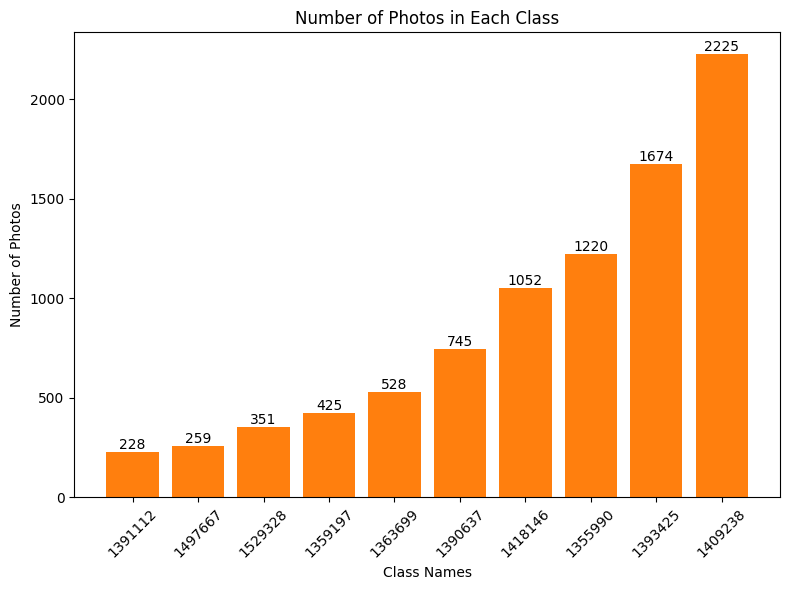

In [58]:
train_path = os.path.join(PATH_TO_PLANTNET_300K, 'train_temp') 
train_dataset = ImageFolder(root=train_path)

class_counts_dict = Counter([label for _, label in train_dataset])
class_counts = np.array([class_counts_dict[i] for i in range(len(train_dataset.classes))])

class_names = sorted(resnet.get_class_names(f'{PATH_TO_PLANTNET_300K}/train_temp'))

sorted_indices = np.argsort(class_counts)
sorted_class_counts = class_counts[sorted_indices]
sorted_class_names = [class_names[i] for i in sorted_indices]


plt.figure(figsize=(8, 6))
plt.bar(sorted_class_names, sorted_class_counts)
bars = plt.bar(sorted_class_names, sorted_class_counts)
for bar, count in zip(bars, sorted_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=10)

plt.title('Number of Photos in Each Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Photos')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


#### Accuray per epoch 

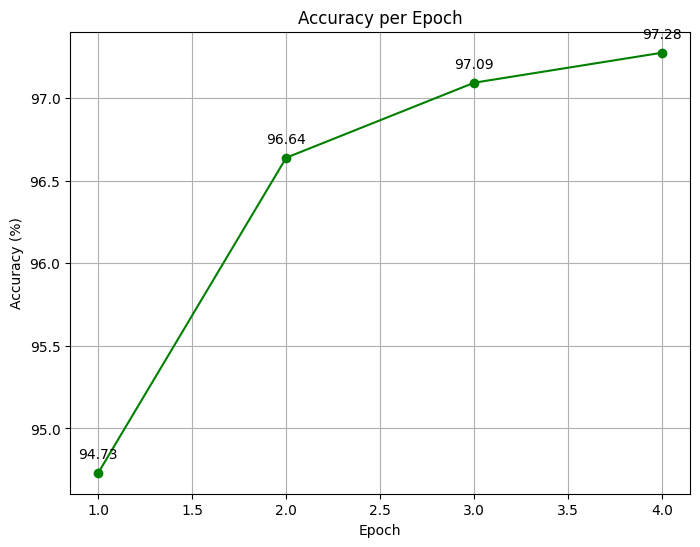

In [26]:
accuracy_per_epoch = [epoch_data['overall_accuracy'] for epoch_data in metrics]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracy_per_epoch) + 1), accuracy_per_epoch, marker='o', color='green')
for i, value in enumerate(accuracy_per_epoch):
    plt.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


#### Confusion Matrix for Last Epoch 

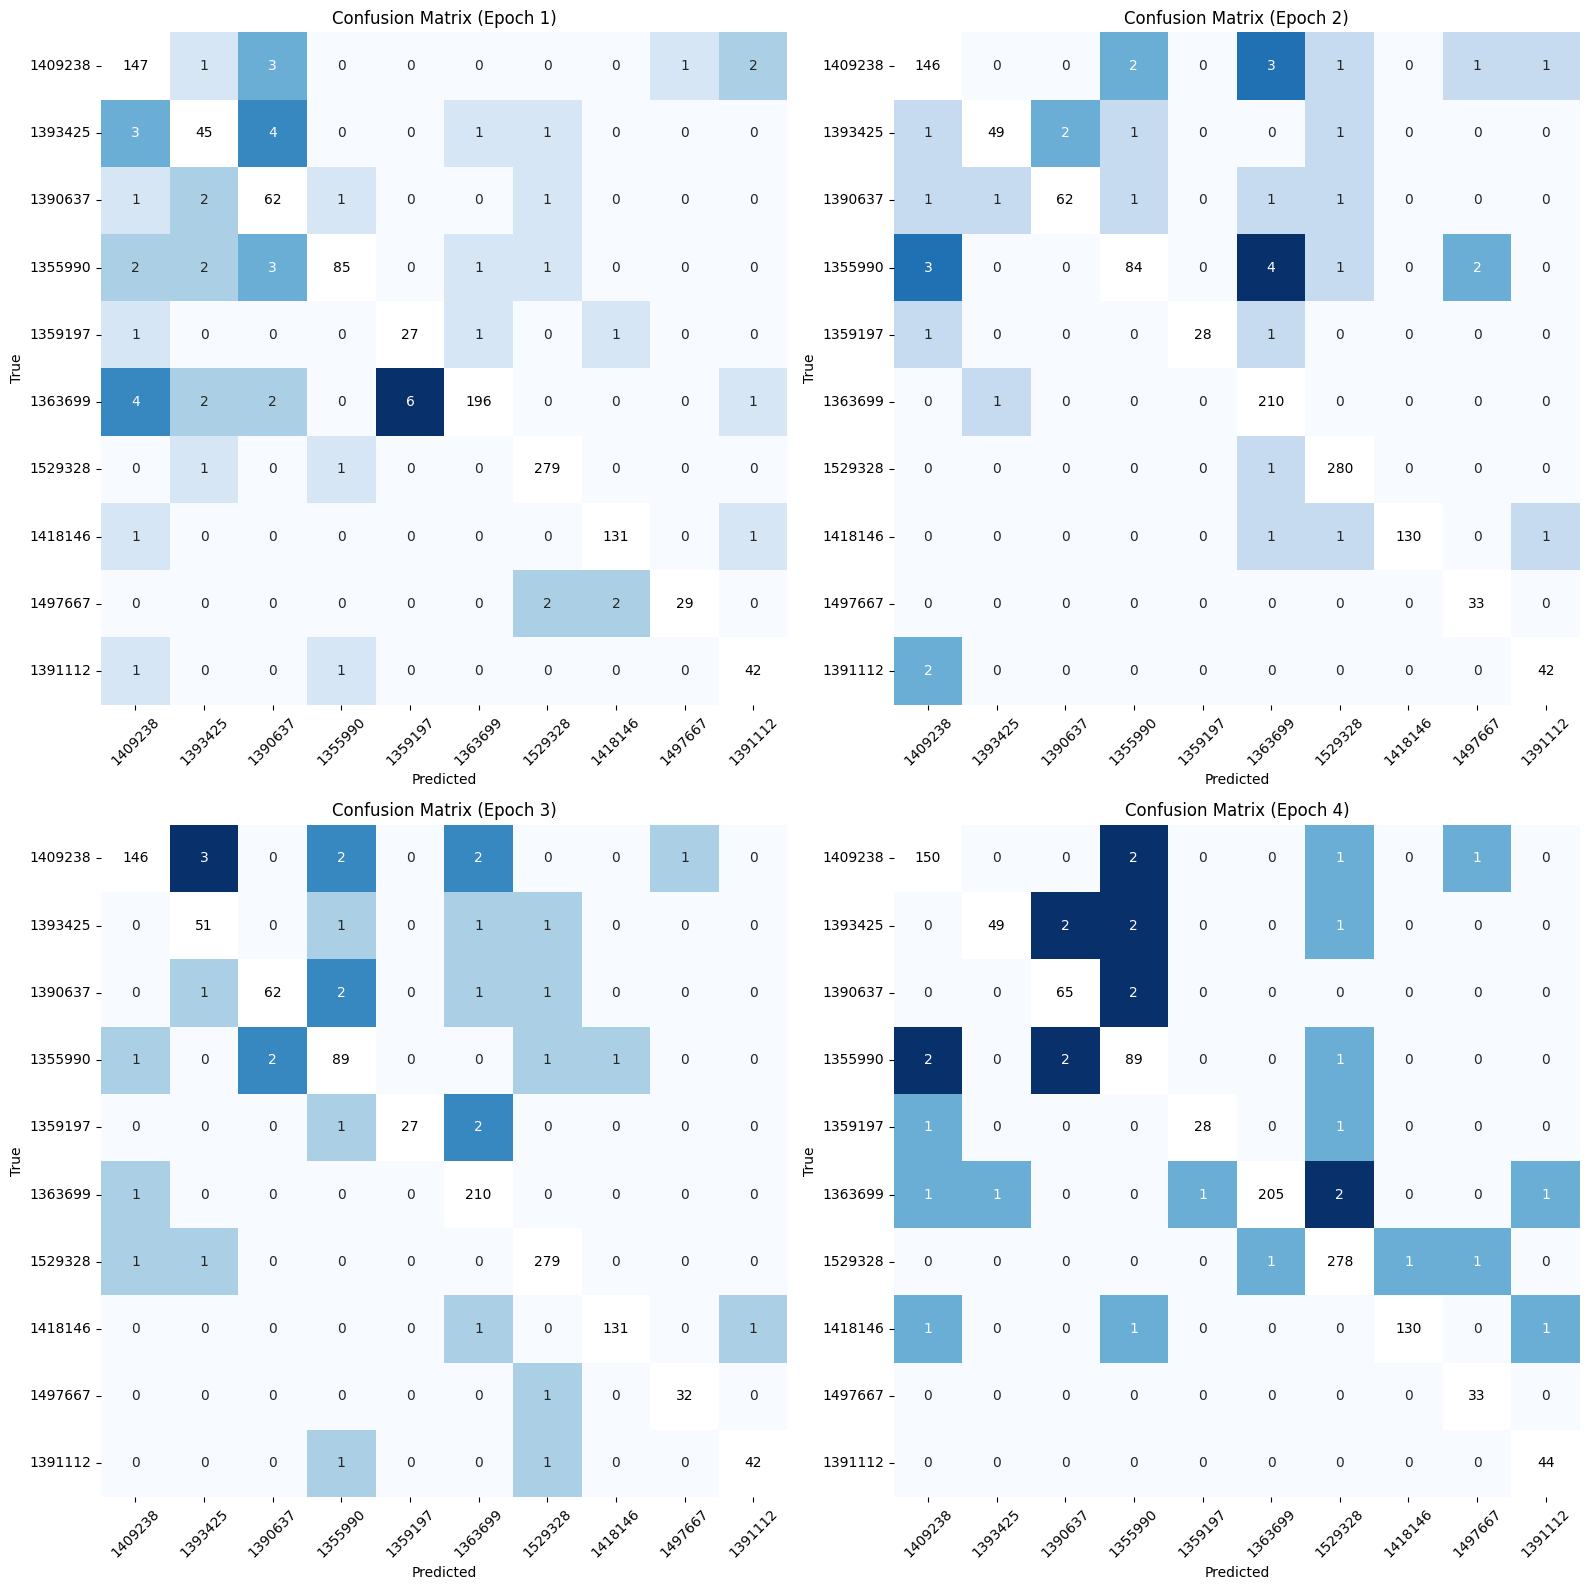

In [53]:
num_epochs = len(metrics)
n_rows = (num_epochs + 1) // 2 

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 8))  # Adjust figure size to match the number of rows

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through each epoch and plot the confusion matrix
for epoch in range(num_epochs):
    # Get confusion matrix for the current epoch
    conf_matrix = metrics[epoch]['confusion_matrix']
    selected_classes = resnet.get_class_names(f'{PATH_TO_PLANTNET_300K}/train_temp') 

    # Create a copy of the confusion matrix for coloring and mask the diagonal
    conf_matrix_for_coloring = conf_matrix.astype(float)
    np.fill_diagonal(conf_matrix_for_coloring, np.nan)

    # Plot the confusion matrix on the respective axis
    sns.heatmap(conf_matrix_for_coloring, annot=conf_matrix, fmt='d', cmap='Blues', ax=axes[epoch],
                xticklabels=selected_classes, yticklabels=selected_classes,
                mask=np.isnan(conf_matrix_for_coloring), 
                cbar=False)  # Disable cbar for clarity in multi-plot
    
    for i in range(len(conf_matrix)):
        axes[epoch].text(i + 0.5, i + 0.5, conf_matrix[i, i], ha="center", va="center", color="black", fontsize=10)

    # Set title for each plot
    axes[epoch].set_title(f'Confusion Matrix (Epoch {epoch + 1})')

    # Modify x-axis labels to be vertical
    axes[epoch].tick_params(axis='x', rotation=45)

    # Set axis labels
    axes[epoch].set_xlabel('Predicted')
    axes[epoch].set_ylabel('True')

# Hide any unused subplots if number of epochs is odd
if num_epochs % 2 != 0:
    axes[-1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()



#### Best and Worst recall

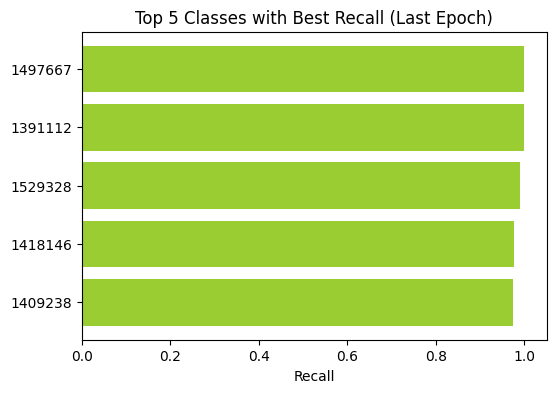

In [59]:
# Get the top 5 best recall classes from the last epoch
top_5_best_recall = metrics[-1]['top_5_best_recall']

# Unpack the data
classes, recalls = zip(*top_5_best_recall)

# Plot best recall classes
plt.figure(figsize=(6, 4))
plt.barh(classes, recalls, color='yellowgreen')
plt.title('Top 5 Classes with Best Recall (Last Epoch)')
plt.xlabel('Recall')
plt.gca().invert_yaxis()
plt.show()

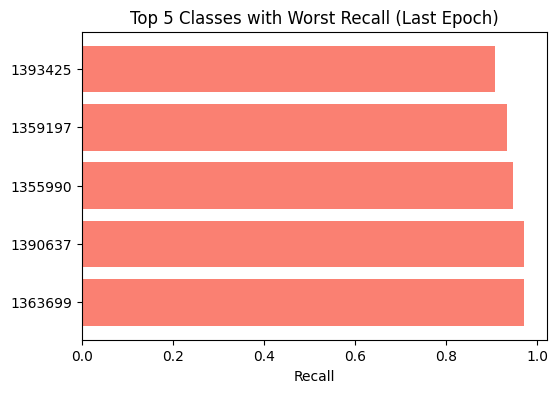

In [35]:
top_5_worst_recall = metrics[-1]['top_5_worst_recall']

classes, recalls = zip(*top_5_worst_recall)

plt.figure(figsize=(6, 4))
plt.barh(classes, recalls, color='salmon')
plt.title('Top 5 Classes with Worst Recall (Last Epoch)')
plt.xlabel('Recall')
plt.gca().invert_yaxis()
plt.show()
